<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/notebooks/4_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part - 4: Proposed and train 3-6 models
 - Compare the model performance using RMSE between the fitted Y and actual Y in testing period

## Importing libraries

In [111]:
# %%bash

# pip install pandas yfinance ta seaborn matplotlib pandas-datareader jinja2 fredapi openpyxl xgboost scikit-learn statsmodels mlflow


In [112]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (15, 20)

## MLFlow Experiment Tracking

In [113]:
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://mlflow.anandpiyush.com"
SET_EXPERIMENT = "INFO7374_team_nvdia"
EXPERIMENT_ID = "5"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(SET_EXPERIMENT)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
mlflow.sklearn.autolog(silent=True)
mlflow.xgboost.autolog(silent=True)
mlflow.statsmodels.autolog()

## NVIDIA Latest Prices

In [114]:
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 12, 31)

NVDA_STOCK = yf.download("NVDA", start_date, end_date)
NVDA_STOCK.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-03,425.170013,428.980011,422.019989,424.130005,424.057770,19820900
2023-07-05,421.350006,431.769989,420.850006,423.170013,423.097961,32361800
2023-07-06,418.440002,421.790009,413.459991,421.029999,420.958313,30358200
2023-07-07,423.220001,432.140015,421.799988,425.029999,424.957642,35525300
2023-07-10,426.570007,428.109985,416.489990,421.799988,421.728149,35390800


## Train & Test Data Split

In [115]:
nvda = pd.read_csv("https://raw.githubusercontent.com/piyush-an/INFO7374_Predict_StockPrice/main/notebooks/NVDA_feature_mart.csv")
nvda.set_index("Unnamed: 0", inplace=True)

nvda.index = pd.to_datetime(nvda.index)
nvda = nvda[nvda.index >= pd.to_datetime("2022-01-01")]
split_date = pd.to_datetime("2023-07-31")

df_train = nvda[nvda.index <= split_date]
df_test = nvda[nvda.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price"]

X_train = df_train.loc[:, df_train.columns != "Close"][:-1]
X_train = X_train.drop(columns_to_drop, axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test.loc[:, df_test.columns != "Close"][:-1]
X_test = X_test.drop(columns_to_drop, axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 393
Number of rows in df_test: 64


## Random Forest Regressors

In [116]:
from itertools import product

# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [1, 2, 4],
}

# Loop through all combinations of hyperparameters
for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_samples_leaf in param_grid["min_samples_leaf"]:
            with mlflow.start_run():
                # Create the model with specific parameters
                model = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                )

                # Fit the model and make predictions
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # Calculate RMSE
                MSE = mean_squared_error(y_test, y_pred, squared=False)
                RMSE = math.sqrt(MSE)

                # Log metrics and parameters to MLflow
                mlflow.set_tag("model", "RandomForestRegressor")
                mlflow.log_metric("RMSE", RMSE)

                print(f"RandomForestRegressor - RMSE: {RMSE:.2f}")

RandomForestRegressor - RMSE: 4.50
RandomForestRegressor - RMSE: 4.60
RandomForestRegressor - RMSE: 4.47
RandomForestRegressor - RMSE: 5.54
RandomForestRegressor - RMSE: 5.18
RandomForestRegressor - RMSE: 5.03
RandomForestRegressor - RMSE: 4.98
RandomForestRegressor - RMSE: 5.06
RandomForestRegressor - RMSE: 4.88
RandomForestRegressor - RMSE: 4.92
RandomForestRegressor - RMSE: 4.66
RandomForestRegressor - RMSE: 4.96
RandomForestRegressor - RMSE: 5.06
RandomForestRegressor - RMSE: 4.92
RandomForestRegressor - RMSE: 4.69
RandomForestRegressor - RMSE: 4.80
RandomForestRegressor - RMSE: 4.85
RandomForestRegressor - RMSE: 4.60
RandomForestRegressor - RMSE: 4.68
RandomForestRegressor - RMSE: 4.80
RandomForestRegressor - RMSE: 5.06
RandomForestRegressor - RMSE: 4.66
RandomForestRegressor - RMSE: 5.27
RandomForestRegressor - RMSE: 5.08
RandomForestRegressor - RMSE: 4.70
RandomForestRegressor - RMSE: 4.93
RandomForestRegressor - RMSE: 4.97


### Retrive the best model


In [117]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'RandomForestRegressor'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"RandomForestRegressor - RMSE: {RMSE}")

Best Run ID: ce28b8f946aa46f783158b71339b5f52


RandomForestRegressor - RMSE: 4.46946778260713


### Plot Actual and Predicted

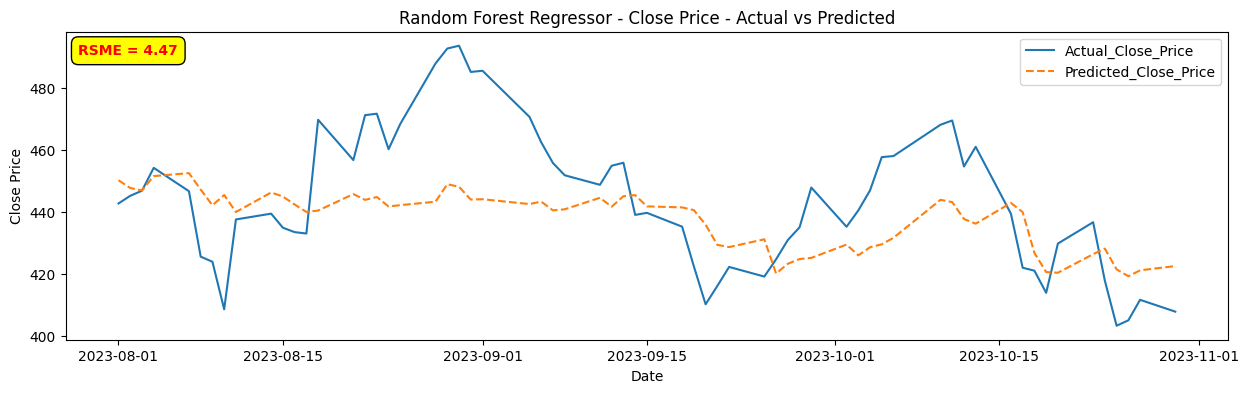

In [118]:
plt.figure(figsize=(15, 4))
plt.plot(y_test, label="Actual_Close_Price", linestyle="solid")
plt.plot(
    pd.Series(y_pred, index=y_test.index),
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Random Forest Regressor - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signals

In [119]:
y_test = y_test.to_frame(name="Actual")
y_test = y_test.rename_axis("Date")
y_pred = pd.Series(y_pred, index=y_test.index)
y_pred = y_pred.to_frame(name="Predicted")
y_pred = y_pred.rename_axis("Date")
results = NVDA_STOCK.merge(y_test, left_index=True, right_index=True, how="inner")
results = results.merge(y_pred, left_index=True, right_index=True, how="inner")
results = results[["Actual", "Predicted", "Open", "Close"]]
results.head()

,Actual,Predicted,Open,Close
Date,,,,
2023-08-01,442.690002,450.169095,464.600006,465.070007
2023-08-02,445.149994,447.670069,458.309998,442.690002
2023-08-03,446.799988,446.893504,438.000000,445.149994
2023-08-04,454.170013,451.504308,449.850006,446.799988
2023-08-07,446.640015,452.470684,451.109985,454.170013


## Ridge Regression

In [120]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [0.1, 0.5, 1.0, 5.0, 10.0]

for alpha in alphas:
    with mlflow.start_run():
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)

        y_pred = ridge.predict(X_test_scaled)
        MSE = mean_squared_error(y_test, y_pred, squared=False)
        RMSE = math.sqrt(MSE)

        mlflow.set_tag("model", "Ridge")
        mlflow.log_metric("RMSE", RMSE)

        print(f"Ridge - RMSE: {RMSE:.2f}")

Ridge - RMSE: 3.42
Ridge - RMSE: 3.49
Ridge - RMSE: 3.54
Ridge - RMSE: 3.72
Ridge - RMSE: 3.96


### Retrive the best model

In [121]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'Ridge'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Ridge - RMSE: {RMSE}")

Best Run ID: 6845949acf7f44c9b2d05c7cbf7ad797


Ridge - RMSE: 3.419473795239898


### Plot Actual and Predicted

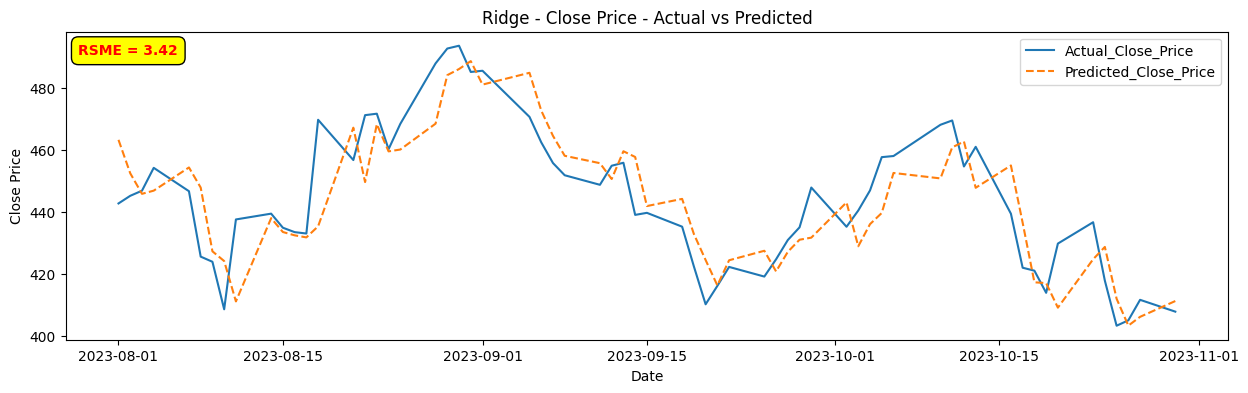

In [122]:
plt.figure(figsize=(15, 4))
plt.plot(y_test, label="Actual_Close_Price", linestyle="solid")
plt.plot(
    pd.Series(y_pred, index=y_test.index),
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Ridge - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## LASSO

In [123]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up a range of alpha values to test
alphas = [5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01, 0.001, 0.0001, 0]

for alpha in alphas:
    with mlflow.start_run():
        lr = Lasso(alpha=alpha, max_iter=10000)
        lr.fit(X_train_scaled, y_train)

        y_pred = lr.predict(X_test_scaled)
        MSE = mean_squared_error(y_test, y_pred, squared=False)

        RMSE = math.sqrt(MSE)
        mlflow.set_tag("model", "Lasso")
        mlflow.log_metric("RMSE", RMSE)

        print(f"Lasso - RMSE: {RMSE:.2f}")

Lasso - RMSE: 3.92
Lasso - RMSE: 3.40
Lasso - RMSE: 3.44
Lasso - RMSE: 3.40


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.548e+03, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.41
Lasso - RMSE: 3.44
Lasso - RMSE: 3.41
Lasso - RMSE: 3.40


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+03, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.41


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e+04, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.41


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+04, tolerance: 2.941e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.41


### Retrive the best model


In [124]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'Lasso'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Lasso - RMSE: {RMSE}")

Best Run ID: c5ece576af564e63a39b8fed6150583a


Lasso - RMSE: 3.398502355502673


### Plot Actual and Predicted

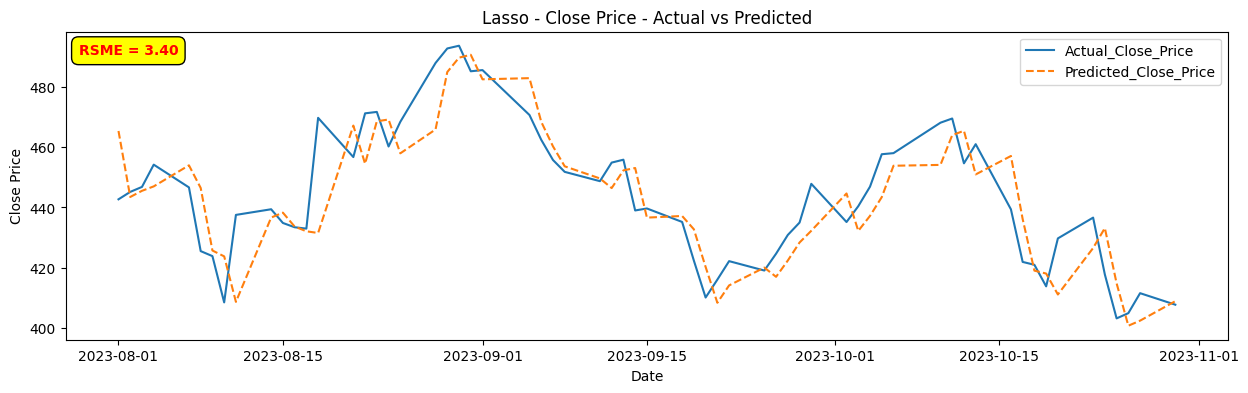

In [125]:
plt.figure(figsize=(15, 4))
plt.plot(y_test, label="Actual_Close_Price", linestyle="solid")
plt.plot(
    pd.Series(y_pred, index=y_test.index),
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Lasso - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## Extreme Gradient Boosting (XGBoost) Regressors


In [126]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_test, label=y_test)

def objective(params):
    with mlflow.start_run():
        # mlflow.log_params(params) # Check here Anku
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
        y_pred = booster.predict(valid)
        MSE = mean_squared_error(y_test, y_pred, squared=False)
        RMSE = math.sqrt(MSE)
        mlflow.set_tag("model", "XGBoost")
        mlflow.log_metric("RMSE", RMSE)

    return {"loss": RMSE, "status": STATUS_OK}

In [ ]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42,
}

best_result = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=Trials()
)

### Retrive the best model


In [128]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'XGBoost'",
)[0].info.run_id

print(f"Best Run ID: {best_run_id}")
loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"XGBoost - RMSE: {RMSE}")

Best Run ID: f916eb0497744517933193ea247cc6b1


XGBoost - RMSE: 4.006368197847673


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:48:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


### Plot Actual and Predicted

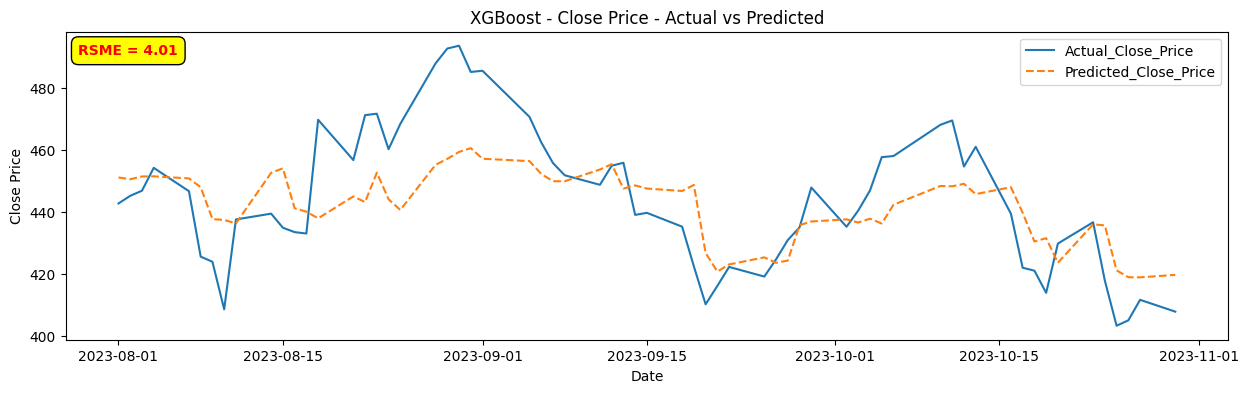

In [129]:
plt.figure(figsize=(15, 4))
plt.plot(y_test, label="Actual_Close_Price", linestyle="solid")
plt.plot(
    pd.Series(y_pred, index=y_test.index),
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("XGBoost - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()